# DAC Codebook Analysis: Noisy Codes Added to Clean (Inverse)

This notebook analyzes which codebooks encode "noisy" information by progressively replacing clean codebooks with noisy ones.

**Pattern**: Variant N has first N codebooks from NOISY, rest from CLEAN

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
import os
import random
from pathlib import Path
import scipy.io.wavfile as wavfile

# Add parent directory to path for dac imports
import sys
sys.path.insert(0, '..')

import dac
from dac.utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Load DAC 16kHz model
model = load_model(model_type="16khz")
model = model.to(device)
model.eval()
print(f"Loaded DAC 16kHz model with {model.n_codebooks} codebooks")

/home/amanag/descript-audio-codec/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Loaded DAC 16kHz model with 12 codebooks


In [3]:
# Load sample data - pick a random pair
sample_dir = Path("../sample_data")
clean_dir = sample_dir / "clean"
noise_dir = sample_dir / "noise"

# Get list of clean files
clean_files = list(clean_dir.glob("*.wav"))
random_clean = random.choice(clean_files)

# Find corresponding noisy file
base_name = random_clean.stem  # e.g., p249_290
noisy_file = list(noise_dir.glob(f"{base_name}*.wav"))[0]

print(f"Selected clean file: {random_clean.name}")
print(f"Selected noisy file: {noisy_file.name}")

Selected clean file: p249_290.wav
Selected noisy file: p249_290_confroom1_iPad_ch1.wav


In [4]:
# Load audio files
def load_audio(filepath, target_sr=16000):
    sr, audio = wavfile.read(filepath)
    # Convert to float32 and normalize
    if audio.dtype == np.int16:
        audio = audio.astype(np.float32) / 32768.0
    elif audio.dtype == np.int32:
        audio = audio.astype(np.float32) / 2147483648.0
    elif audio.dtype == np.float64:
        audio = audio.astype(np.float32)
    
    # Ensure mono
    if len(audio.shape) > 1:
        audio = audio.mean(axis=1)
    
    return audio, sr

clean_audio, sr_clean = load_audio(random_clean)
noisy_audio, sr_noisy = load_audio(noisy_file)

print(f"Clean audio: {len(clean_audio)} samples, {sr_clean} Hz, duration: {len(clean_audio)/sr_clean:.2f}s")
print(f"Noisy audio: {len(noisy_audio)} samples, {sr_noisy} Hz, duration: {len(noisy_audio)/sr_noisy:.2f}s")

Clean audio: 56537 samples, 16000 Hz, duration: 3.53s
Noisy audio: 56537 samples, 16000 Hz, duration: 3.53s


In [5]:
# Make sure both audios have same length (use minimum)
min_len = min(len(clean_audio), len(noisy_audio))
clean_audio = clean_audio[:min_len]
noisy_audio = noisy_audio[:min_len]

print(f"Aligned length: {min_len} samples ({min_len/16000:.2f}s)")

Aligned length: 56537 samples (3.53s)


ORIGINAL CLEAN AUDIO


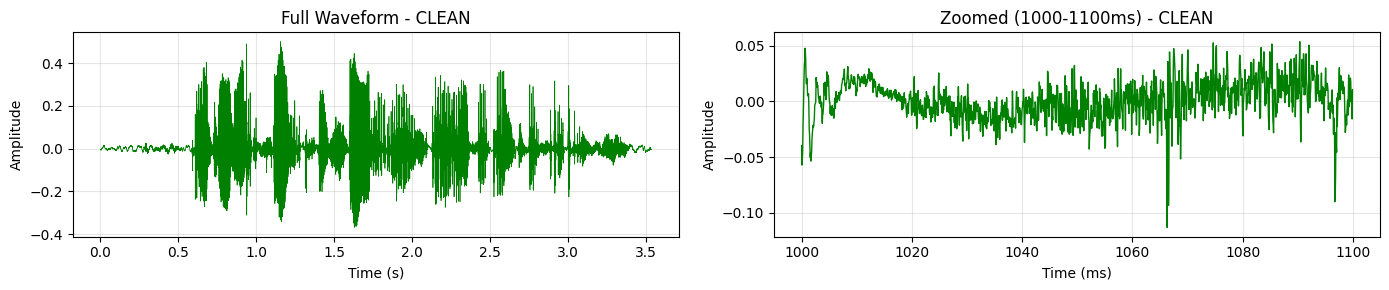


ORIGINAL NOISY AUDIO


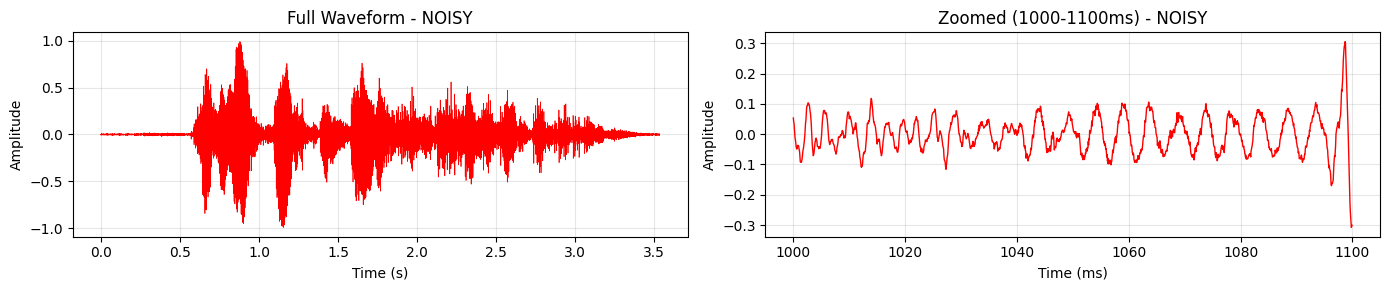

In [6]:
# Original Clean and Noisy Audio with Waveforms

# === CLEAN AUDIO ===
print("=" * 60)
print("ORIGINAL CLEAN AUDIO")
print("=" * 60)
display(Audio(clean_audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Full waveform - Clean
time_full = np.arange(len(clean_audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Full Waveform - CLEAN')
axes[0].grid(True, alpha=0.3)

# Zoomed waveform - Clean (100ms starting from 1 second = 1600 samples at 16kHz)
zoom_start = 16000  # 1 second
zoom_samples = 1600  # 100ms
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000  # Convert to ms, offset by 1000ms
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Zoomed (1000-1100ms) - CLEAN')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === NOISY AUDIO ===
print("\n" + "=" * 60)
print("ORIGINAL NOISY AUDIO")
print("=" * 60)
display(Audio(noisy_audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

# Full waveform - Noisy
time_full = np.arange(len(noisy_audio)) / 16000
axes[0].plot(time_full, noisy_audio, linewidth=0.5, color='red')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Full Waveform - NOISY')
axes[0].grid(True, alpha=0.3)

# Zoomed waveform - Noisy
axes[1].plot(time_zoom, noisy_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='red')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Zoomed (1000-1100ms) - NOISY')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Encode both audios with DAC
def encode_audio(model, audio, device):
    """Encode audio and return codes"""
    # Prepare input: [B, 1, T]
    audio_tensor = torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0).to(device)
    
    # Preprocess (padding)
    audio_tensor = model.preprocess(audio_tensor, sample_rate=16000)
    
    with torch.no_grad():
        z, codes, latents, _, _ = model.encode(audio_tensor)
    
    return codes, z

clean_codes, clean_z = encode_audio(model, clean_audio, device)
noisy_codes, noisy_z = encode_audio(model, noisy_audio, device)

print(f"Clean codes shape: {clean_codes.shape}")
print(f"Noisy codes shape: {noisy_codes.shape}")
print(f"\nCodes shape is [batch, n_codebooks, time_steps]")
print(f"Number of codebooks: {clean_codes.shape[1]}")
print(f"Number of time steps: {clean_codes.shape[2]}")

Clean codes shape: torch.Size([1, 12, 177])
Noisy codes shape: torch.Size([1, 12, 177])

Codes shape is [batch, n_codebooks, time_steps]
Number of codebooks: 12
Number of time steps: 177


In [8]:
# Function to create INVERSE hybrid codes and decode
# INVERSE: first n codebooks from NOISY, rest from CLEAN
def create_hybrid_inverse_and_decode(model, clean_codes, noisy_codes, n_noisy_codebooks, device):
    """
    Create hybrid codes where first n_noisy_codebooks are from NOISY,
    and the rest are from CLEAN.
    
    n_noisy_codebooks: 1 to 12
    - 1 means: [N, C, C, C, C, C, C, C, C, C, C, C]
    - 12 means: [N, N, N, N, N, N, N, N, N, N, N, N] (all noisy)
    """
    n_codebooks = clean_codes.shape[1]
    
    # Create hybrid codes
    hybrid_codes = torch.zeros_like(clean_codes)
    
    # First n_noisy_codebooks from NOISY
    hybrid_codes[:, :n_noisy_codebooks, :] = noisy_codes[:, :n_noisy_codebooks, :]
    
    # Rest from CLEAN
    hybrid_codes[:, n_noisy_codebooks:, :] = clean_codes[:, n_noisy_codebooks:, :]
    
    # Decode using quantizer.from_codes
    with torch.no_grad():
        z_q, _, _ = model.quantizer.from_codes(hybrid_codes)
        decoded_audio = model.decode(z_q)
    
    return decoded_audio.squeeze().cpu().numpy(), hybrid_codes

# Test with one hybrid
test_audio, test_codes = create_hybrid_inverse_and_decode(model, clean_codes, noisy_codes, 1, device)
print(f"Decoded audio shape: {test_audio.shape}")

Decoded audio shape: (56632,)


In [9]:
# Generate all 12 INVERSE hybrid waveforms
n_codebooks = clean_codes.shape[1]
hybrid_audios = []

for n_noisy in range(1, n_codebooks + 1):
    audio, codes = create_hybrid_inverse_and_decode(model, clean_codes, noisy_codes, n_noisy, device)
    hybrid_audios.append(audio)
    
    # Create label showing which codebooks are noisy (N) vs clean (C)
    label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
    print(f"Hybrid {n_noisy:2d}: {' '.join(label)}")

print(f"\nGenerated {len(hybrid_audios)} inverse hybrid waveforms")

# Helper function to calculate metrics
def calculate_metrics(clean, generated):
    """Calculate MSE, SNR, and correlation between clean and generated audio"""
    # Ensure same length
    min_len = min(len(clean), len(generated))
    clean = clean[:min_len]
    generated = generated[:min_len]
    
    # MSE
    mse = np.mean((clean - generated) ** 2)
    
    # SNR (Signal-to-Noise Ratio in dB)
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - generated) ** 2)
    if noise_power > 0:
        snr = 10 * np.log10(signal_power / noise_power)
    else:
        snr = float('inf')
    
    # Correlation
    corr = np.corrcoef(clean, generated)[0, 1]
    
    return mse, snr, corr

print("\n" + "=" * 60)
print("Reference: Metrics for Original Noisy vs Clean")
print("=" * 60)
mse_noisy, snr_noisy, corr_noisy = calculate_metrics(clean_audio, noisy_audio)
print(f"MSE: {mse_noisy:.6f} | SNR: {snr_noisy:.2f} dB | Correlation: {corr_noisy:.4f}")

Hybrid  1: N C C C C C C C C C C C
Hybrid  2: N N C C C C C C C C C C
Hybrid  3: N N N C C C C C C C C C
Hybrid  4: N N N N C C C C C C C C
Hybrid  5: N N N N N C C C C C C C
Hybrid  6: N N N N N N C C C C C C
Hybrid  7: N N N N N N N C C C C C
Hybrid  8: N N N N N N N N C C C C
Hybrid  9: N N N N N N N N N C C C
Hybrid 10: N N N N N N N N N N C C
Hybrid 11: N N N N N N N N N N N C
Hybrid 12: N N N N N N N N N N N N

Generated 12 inverse hybrid waveforms

Reference: Metrics for Original Noisy vs Clean
MSE: 0.023259 | SNR: -6.81 dB | Correlation: 0.4855


---
## Inverse Hybrid Waveform Analysis

Below are 12 cells, each showing:
1. Audio player
2. Full waveform plot (with clean overlay)
3. Zoomed waveform (1000-1100ms, with clean overlay)

**Pattern**: Hybrid N has first N codebooks from NOISY, rest from CLEAN

Hybrid 1: N C C C C C C C C C C C
MSE: 0.015791 | SNR: -5.13 dB | Correlation: 0.2573


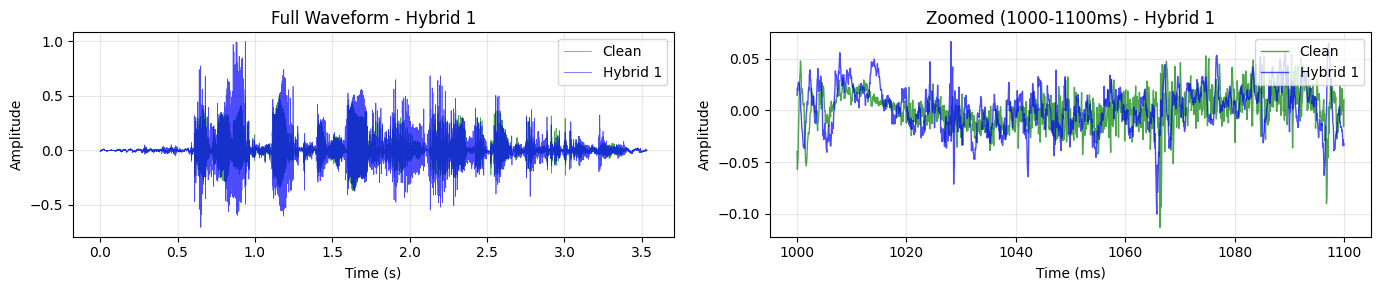

In [10]:
# Hybrid 1: [N, C, C, C, C, C, C, C, C, C, C, C] - 1 noisy, 11 clean
idx = 0
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

# Calculate metrics
mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 2: N N C C C C C C C C C C
MSE: 0.018978 | SNR: -5.92 dB | Correlation: 0.3031


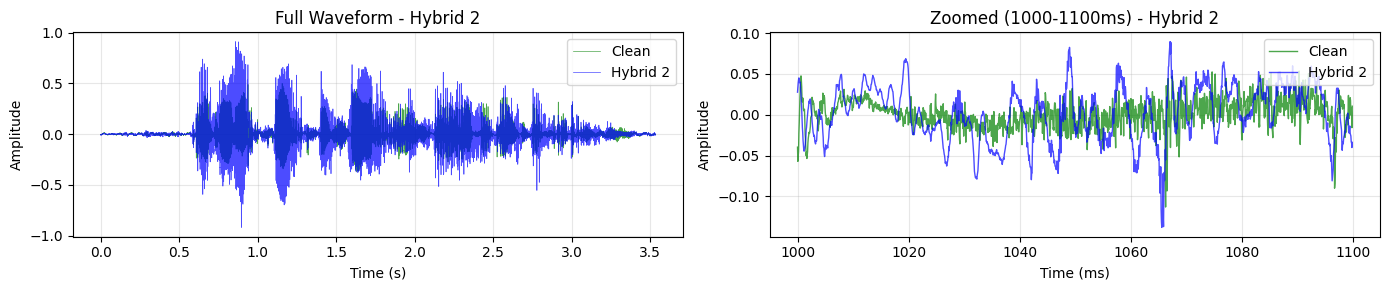

In [11]:
# Hybrid 2: [N, N, C, C, C, C, C, C, C, C, C, C] - 2 noisy, 10 clean
idx = 1
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 3: N N N C C C C C C C C C
MSE: 0.019902 | SNR: -6.13 dB | Correlation: 0.3245


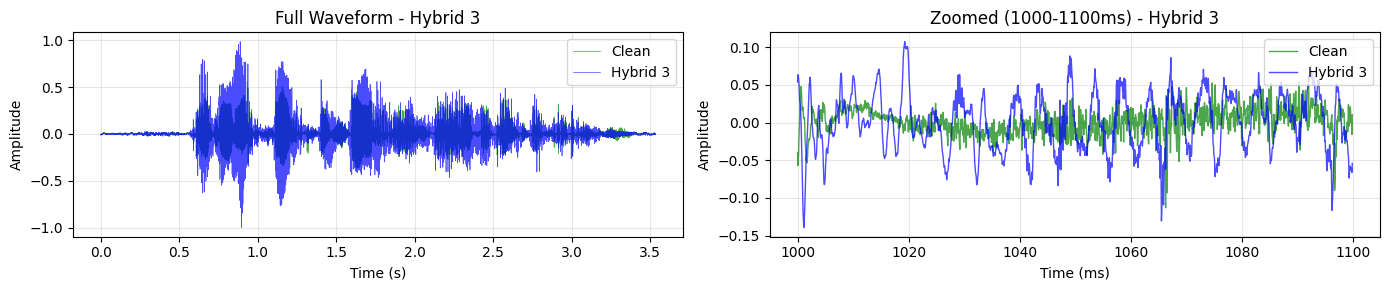

In [12]:
# Hybrid 3: [N, N, N, C, C, C, C, C, C, C, C, C] - 3 noisy, 9 clean
idx = 2
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 4: N N N N C C C C C C C C
MSE: 0.020040 | SNR: -6.16 dB | Correlation: 0.3349


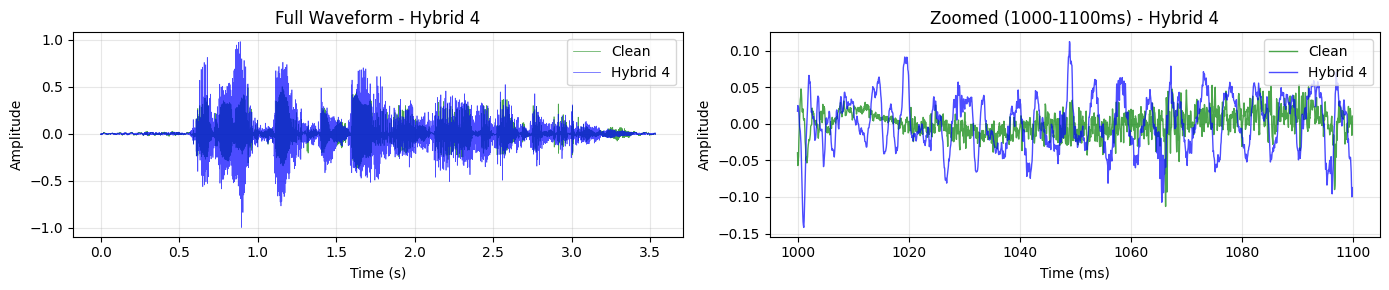

In [13]:
# Hybrid 4: [N, N, N, N, C, C, C, C, C, C, C, C] - 4 noisy, 8 clean
idx = 3
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 5: N N N N N C C C C C C C
MSE: 0.021030 | SNR: -6.37 dB | Correlation: 0.3347


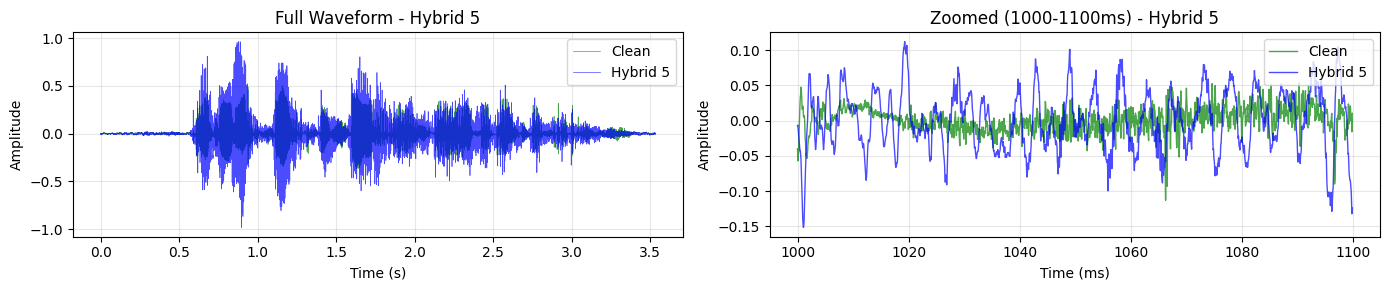

In [14]:
# Hybrid 5: [N, N, N, N, N, C, C, C, C, C, C, C] - 5 noisy, 7 clean
idx = 4
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 6: N N N N N N C C C C C C
MSE: 0.022000 | SNR: -6.57 dB | Correlation: 0.3423


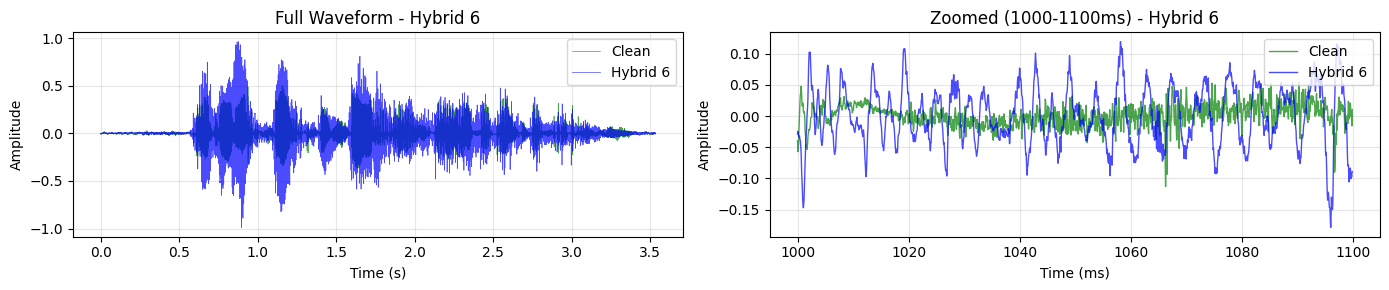

In [15]:
# Hybrid 6: [N, N, N, N, N, N, C, C, C, C, C, C] - 6 noisy, 6 clean
idx = 5
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 7: N N N N N N N C C C C C
MSE: 0.022684 | SNR: -6.70 dB | Correlation: 0.3151


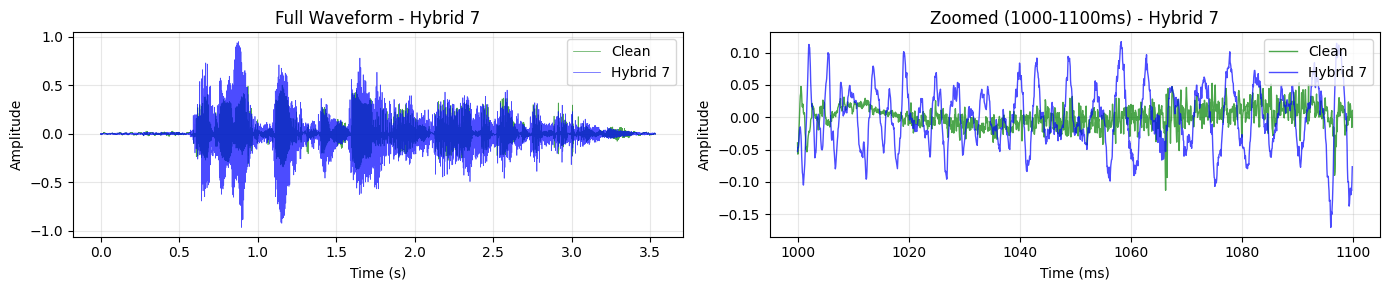

In [16]:
# Hybrid 7: [N, N, N, N, N, N, N, C, C, C, C, C] - 7 noisy, 5 clean
idx = 6
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 8: N N N N N N N N C C C C
MSE: 0.023230 | SNR: -6.80 dB | Correlation: 0.3073


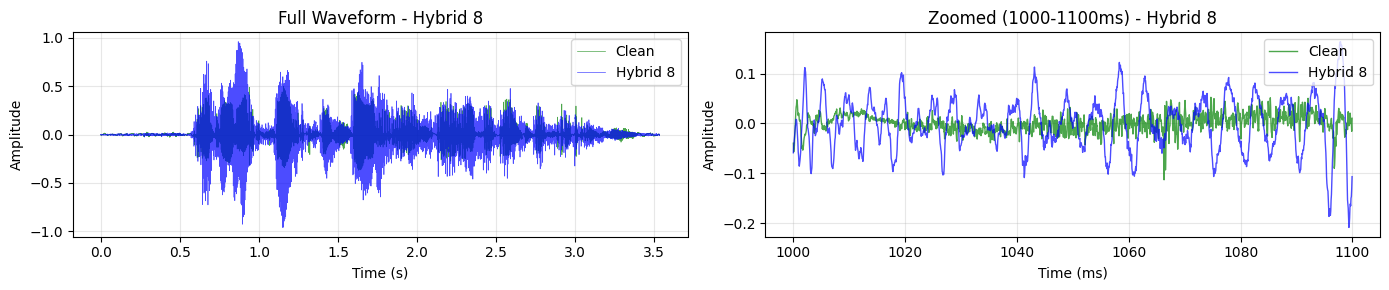

In [17]:
# Hybrid 8: [N, N, N, N, N, N, N, N, C, C, C, C] - 8 noisy, 4 clean
idx = 7
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 9: N N N N N N N N N C C C
MSE: 0.023997 | SNR: -6.94 dB | Correlation: 0.3009


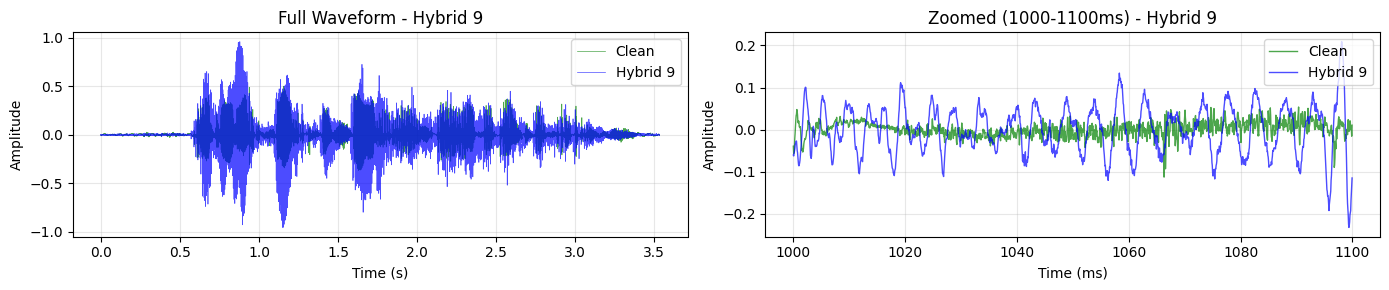

In [18]:
# Hybrid 9: [N, N, N, N, N, N, N, N, N, C, C, C] - 9 noisy, 3 clean
idx = 8
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 10: N N N N N N N N N N C C
MSE: 0.024661 | SNR: -7.06 dB | Correlation: 0.3042


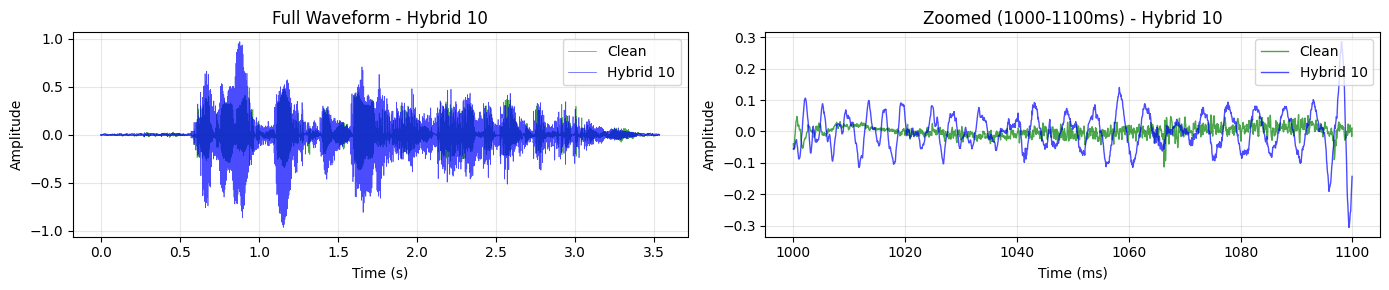

In [19]:
# Hybrid 10: [N, N, N, N, N, N, N, N, N, N, C, C] - 10 noisy, 2 clean
idx = 9
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 11: N N N N N N N N N N N C
MSE: 0.025692 | SNR: -7.24 dB | Correlation: 0.3056


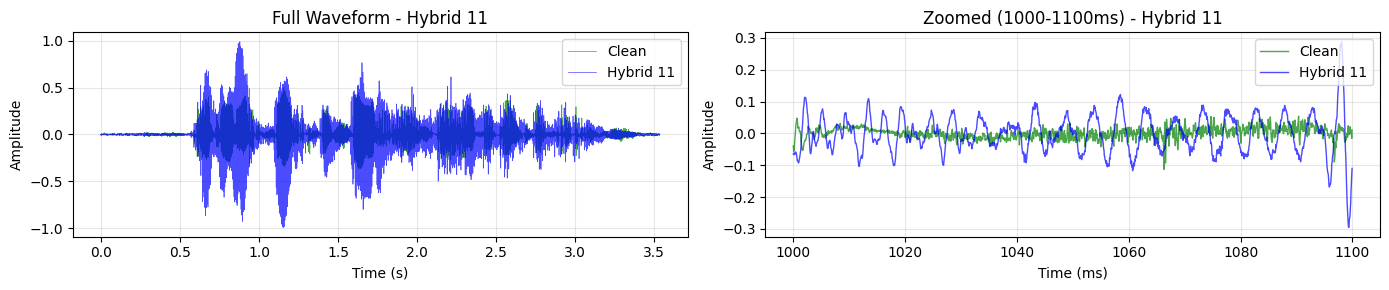

In [20]:
# Hybrid 11: [N, N, N, N, N, N, N, N, N, N, N, C] - 11 noisy, 1 clean
idx = 10
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)}")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy}')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hybrid 12: N N N N N N N N N N N N (Fully Noisy Reconstruction)
MSE: 0.025893 | SNR: -7.27 dB | Correlation: 0.3097


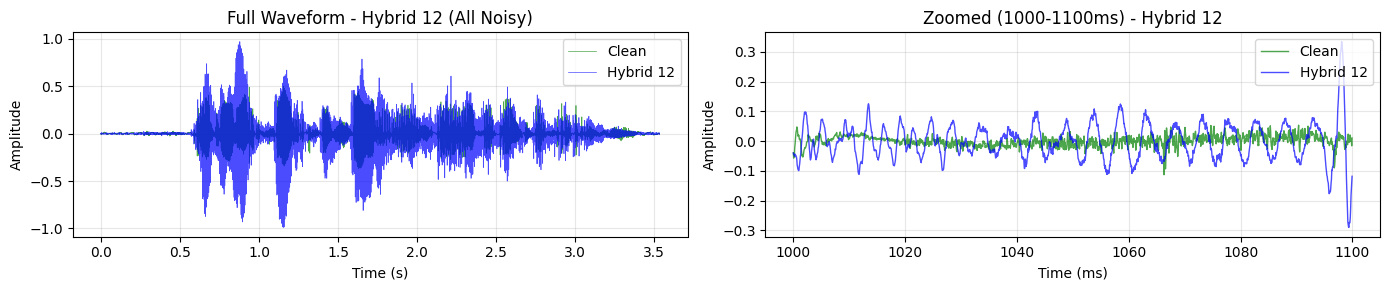

In [21]:
# Hybrid 12: [N, N, N, N, N, N, N, N, N, N, N, N] - 12 noisy, 0 clean (fully noisy reconstruction)
idx = 11
n_noisy = idx + 1
label = ['N'] * n_noisy + ['C'] * (n_codebooks - n_noisy)
audio = hybrid_audios[idx][:min_len]

mse, snr, corr = calculate_metrics(clean_audio, audio)

print(f"Hybrid {n_noisy}: {' '.join(label)} (Fully Noisy Reconstruction)")
print(f"MSE: {mse:.6f} | SNR: {snr:.2f} dB | Correlation: {corr:.4f}")
display(Audio(audio, rate=16000))

fig, axes = plt.subplots(1, 2, figsize=(14, 3))

time_full = np.arange(len(audio)) / 16000
axes[0].plot(time_full, clean_audio, linewidth=0.5, color='green', alpha=0.7, label='Clean')
axes[0].plot(time_full, audio, linewidth=0.5, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title(f'Full Waveform - Hybrid {n_noisy} (All Noisy)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

zoom_start = 16000
zoom_samples = 1600
time_zoom = np.arange(zoom_samples) / 16000 * 1000 + 1000
axes[1].plot(time_zoom, clean_audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='green', alpha=0.7, label='Clean')
axes[1].plot(time_zoom, audio[zoom_start:zoom_start+zoom_samples], linewidth=1, color='blue', alpha=0.7, label=f'Hybrid {n_noisy}')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title(f'Zoomed (1000-1100ms) - Hybrid {n_noisy}')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Generate metrics JSON for all 5 files x 12 variants x 3 metrics (INVERSE)
import json

# Get all clean files
all_clean_files = sorted(list(clean_dir.glob("*.wav")))
print(f"Found {len(all_clean_files)} clean files")

results = {
    "experiment": "inverse",
    "description": "First N codebooks from NOISY, rest from CLEAN",
    "files": [],
    "metrics": ["mse", "snr", "correlation"],
    "n_variants": 12,
    "data": []  # Shape: [n_files, 12, 3]
}

for file_idx, clean_file in enumerate(all_clean_files):
    base_name = clean_file.stem
    noisy_file = list(noise_dir.glob(f"{base_name}*.wav"))[0]
    
    print(f"\nProcessing file {file_idx + 1}/5: {base_name}")
    results["files"].append(base_name)
    
    # Load audio
    clean_aud, _ = load_audio(clean_file)
    noisy_aud, _ = load_audio(noisy_file)
    
    # Align lengths
    min_length = min(len(clean_aud), len(noisy_aud))
    clean_aud = clean_aud[:min_length]
    noisy_aud = noisy_aud[:min_length]
    
    # Encode both
    clean_c, _ = encode_audio(model, clean_aud, device)
    noisy_c, _ = encode_audio(model, noisy_aud, device)
    
    # Generate 12 INVERSE variants and calculate metrics
    file_metrics = []  # [12, 3]
    
    for n_noisy in range(1, 13):
        hybrid_aud, _ = create_hybrid_inverse_and_decode(model, clean_c, noisy_c, n_noisy, device)
        hybrid_aud = hybrid_aud[:min_length]
        
        mse, snr, corr = calculate_metrics(clean_aud, hybrid_aud)
        file_metrics.append([float(mse), float(snr), float(corr)])
        
        label = ['N'] * n_noisy + ['C'] * (12 - n_noisy)
        print(f"  Variant {n_noisy:2d} ({' '.join(label)}): MSE={mse:.6f}, SNR={snr:.2f}dB, Corr={corr:.4f}")
    
    results["data"].append(file_metrics)

# Convert to the exact shape requested: [5, 12, 3]
print(f"\n{'='*60}")
print(f"Results shape: [{len(results['data'])}, {len(results['data'][0])}, {len(results['data'][0][0])}]")
print(f"Files: {results['files']}")
print(f"Metrics order: {results['metrics']}")

# Save to JSON file
json_output_path = "../sample_data/codebook_metrics_inverse.json"
with open(json_output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nJSON saved to: {json_output_path}")

# Also display the JSON
print(f"\n{'='*60}")
print("JSON Output:")
print(json.dumps(results, indent=2))

Found 5 clean files

Processing file 1/5: p249_290
  Variant  1 (N C C C C C C C C C C C): MSE=0.015814, SNR=-5.13dB, Corr=0.2573
  Variant  2 (N N C C C C C C C C C C): MSE=0.019016, SNR=-5.93dB, Corr=0.3030
  Variant  3 (N N N C C C C C C C C C): MSE=0.019921, SNR=-6.13dB, Corr=0.3247
  Variant  4 (N N N N C C C C C C C C): MSE=0.020089, SNR=-6.17dB, Corr=0.3348
  Variant  5 (N N N N N C C C C C C C): MSE=0.021053, SNR=-6.37dB, Corr=0.3350
  Variant  6 (N N N N N N C C C C C C): MSE=0.022023, SNR=-6.57dB, Corr=0.3424
  Variant  7 (N N N N N N N C C C C C): MSE=0.022706, SNR=-6.70dB, Corr=0.3157
  Variant  8 (N N N N N N N N C C C C): MSE=0.023250, SNR=-6.81dB, Corr=0.3081
  Variant  9 (N N N N N N N N N C C C): MSE=0.024004, SNR=-6.94dB, Corr=0.3016
  Variant 10 (N N N N N N N N N N C C): MSE=0.024687, SNR=-7.07dB, Corr=0.3051
  Variant 11 (N N N N N N N N N N N C): MSE=0.025678, SNR=-7.24dB, Corr=0.3060
  Variant 12 (N N N N N N N N N N N N): MSE=0.025893, SNR=-7.27dB, Corr=0.3097

